<a href="https://colab.research.google.com/github/linaskova/cv_prediction_app/blob/main/project_yandex_sbor_4_ipynb_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Цель проекта: разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

Описание данных

В файле train_dataset.csv собрана информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

В папке train_images содержатся изображения для тренировки модели.

В файле CrowdAnnotations.tsv — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

Имя файла изображения.

Идентификатор описания.

Доля людей, подтвердивших, что описание соответствует изображению.

Количество человек, подтвердивших, что описание соответствует изображению.

Количество человек, подтвердивших, что описание не соответствует
изображению.

В файле ExpertAnnotations.tsv содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

Имя файла изображения.

Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле test_queries.csv находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний.

Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

В папке test_images содержатся изображения для тестирования модели.

#1. Исследовательский анализ данных


Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

Доля исполнителей, подтвердивших, что текст соответствует картинке.

Количество исполнителей, подтвердивших, что текст соответствует картинке.

Количество исполнителей, подтвердивших, что текст не соответствует картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.

In [220]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [221]:
!pip install -q --upgrade keras-nlp

In [222]:
!pip install transformers

In [223]:
#импортируем библиотеки
import os
import warnings
import time
from tqdm import tqdm
from tqdm import notebook
tqdm.pandas()


from PIL import Image
from pathlib import Path

import math
from scipy import stats as st
import numpy as np
import scipy
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords') # поддерживает удаление стоп-слов
nltk.download('punkt') # делит текст на список предложений
nltk.download('wordnet') # проводит лемматизацию
nltk.download('omw-1.4')


import torchvision.models as models
from torchvision import transforms
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split, GridSearchCV, GroupShuffleSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, log_loss, f1_score, mean_squared_error


import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D, BatchNormalization, Reshape, RepeatVector, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
import tensorflow as ts

import keras_nlp

from google.colab import files

from transformers import BertModel, BertTokenizer, logging
from scipy.spatial.distance import cosine

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [224]:
#загрузим данные для проекта
#uploaded = files.upload()
path_ = '/content/drive/MyDrive'
image_path_for_f =  '/content/drive/MyDrive/train_images'

seed_ = 12345

plt.style.use('ggplot')
logging.set_verbosity_error()

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')


In [225]:
for dirpath, _, filenames in os.walk('/content/'):

  for filename in filenames:
    print(os.path.join(dirpath, filename))

/content/.config/default_configs.db
/content/.config/gce
/content/.config/.last_update_check.json
/content/.config/.last_survey_prompt.yaml
/content/.config/config_sentinel
/content/.config/.last_opt_in_prompt.yaml
/content/.config/active_config
/content/.config/configurations/config_default
/content/.config/logs/2023.09.12/13.22.02.690394.log
/content/.config/logs/2023.09.12/13.21.36.563326.log
/content/.config/logs/2023.09.12/13.20.35.991971.log
/content/.config/logs/2023.09.12/13.22.01.954489.log
/content/.config/logs/2023.09.12/13.21.27.881632.log
/content/.config/logs/2023.09.12/13.21.03.978971.log
/content/drive/MyDrive/Актуарный экзамен.7z
/content/drive/MyDrive/gradient_model_prese.pdf
/content/drive/MyDrive/gradient_model_prese.gdoc
/content/drive/MyDrive/Черновик.gdoc
/content/drive/MyDrive/text_pre.csv
/content/drive/MyDrive/train_dataset.csv
/content/drive/MyDrive/.DS_Store
/content/drive/MyDrive/test_queries.csv
/content/drive/MyDrive/test_images.csv
/content/drive/MyDriv

In [226]:
#загрузили данные в датасеты
data_train = pd.read_csv('/content/drive/MyDrive/train_dataset.csv')
test_images = pd.read_csv('/content/drive/MyDrive/test_images.csv', sep='|')
test_queries = pd.read_csv('/content/drive/MyDrive/test_queries.csv',index_col=[0], sep='|')
CrowdAnnotations = pd.read_csv('/content/drive/MyDrive/CrowdAnnotations.tsv', sep='\t',
                           names=['image', 'query_id', 'share_pos', 'count_pos', 'count_neg'])
ExpertAnnotations = pd.read_csv('/content/drive/MyDrive/ExpertAnnotations.tsv', sep='\t',
                           names=['image', 'query_id', 'first', 'second', 'third'])


#1.1.Немного EDA

In [227]:
#проанализируем датасеты
display(data_train.head(), test_images.head(), test_queries.head(), CrowdAnnotations.head(), ExpertAnnotations.head())
display(data_train.describe(), test_images.describe(), test_queries.describe(), CrowdAnnotations.describe(), ExpertAnnotations.describe())
display(data_train.info(), test_images.info(), test_queries.info(), CrowdAnnotations.info(), ExpertAnnotations.info())


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

image                     query_id  share_pos  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2        1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2        0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2        0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2        0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2        0.0   

   count_pos  count_neg  
0          3          0  
1          0          3  
2          0          3  
3          0          3  
4          0          3

image                     query_id  first  second  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1       1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1       1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1       1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2      1       2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2      1       1   

   third  
0      1  
1      2  
2      2  
3      2  
4      2

image                     query_id  \
count                        5822                         5822   
unique                       1000                          977   
top     3364151356_eecd07a23e.jpg  2600867924_cd502fc911.jpg#2   
freq                           10                           34   

                                               query_text  
count                                                5822  
unique                                                977  
top     Two dogs , one brown and white and one black a...  
freq                                                   34

image
count                         100
unique                        100
top     3356748019_2251399314.jpg
freq                            1

query_id  \
count                           500   
unique                          500   
top     1177994172_10d143cb8d.jpg#0   
freq                              1   

                                               query_text  \
count                                                 500   
unique                                                500   
top     Two blonde boys , one in a camouflage shirt an...   
freq                                                    1   

                            image  
count                         500  
unique                        100  
top     1177994172_10d143cb8d.jpg  
freq                            5

share_pos     count_pos     count_neg
count  47830.000000  47830.000000  47830.000000
mean       0.068786      0.208488      2.820155
std        0.207532      0.628898      0.656676
min        0.000000      0.000000      0.000000
25%        0.000000      0.000000      3.000000
50%        0.000000      0.000000      3.000000
75%        0.000000      0.000000      3.000000
max        1.000000      5.000000      6.000000

first       second        third
count  5822.000000  5822.000000  5822.000000
mean      1.436620     1.624356     1.881999
std       0.787084     0.856222     0.904087
min       1.000000     1.000000     1.000000
25%       1.000000     1.000000     1.000000
50%       1.000000     1.000000     2.000000
75%       2.000000     2.000000     2.000000
max       4.000000     4.000000     4.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes
<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4

None

None

None

None

None

In [228]:
data_train_columns = data_train.columns.values
test_images_columns = test_images.columns.values
test_queries_columns = test_queries.columns.values
CrowdAnnotations_columns = CrowdAnnotations.columns.values
ExpertAnnotations_columns = ExpertAnnotations.columns.values

def isna_data(data,columns):
    global count
    count = 0
    error = []
    for i in range(len(columns)):
        if data[data[columns[i]].isna()].shape[0] != 0:
            print('В столбце',columns[i],'количество пустых значение равно доле:',
                        data[data[columns[i]].isna()].shape[0]/data.shape[0])
        else: count+=1

    if count!=0:
        print('В датафрейме из числа признаков',data.shape[1],'не имеют пустых значений следующее количество', count)

isna_data(data_train,data_train_columns)
isna_data(test_images,test_images_columns)
isna_data(test_queries,test_queries_columns)
isna_data(CrowdAnnotations,CrowdAnnotations_columns)
isna_data(ExpertAnnotations,ExpertAnnotations_columns)

В датафрейме из числа признаков 3 не имеют пустых значений следующее количество 3
В датафрейме из числа признаков 1 не имеют пустых значений следующее количество 1
В датафрейме из числа признаков 3 не имеют пустых значений следующее количество 3
В датафрейме из числа признаков 5 не имеют пустых значений следующее количество 5
В датафрейме из числа признаков 5 не имеют пустых значений следующее количество 5


In [229]:
#проанализируем дубликаты
def dubl(data):
  i = data.drop_duplicates().shape[0]/data.shape[0]
  name =[x for x in globals() if globals()[x] is data][0]
  if i == 1:
    print('дубликатов в датафрейме', name, 'не найдено')
  else: print('дубликаты в датафрейме', name, 'найдены, их соотношение', 1- i)

dubl(data_train)
dubl(test_images)
dubl(test_queries)
dubl(CrowdAnnotations)
dubl(ExpertAnnotations)

дубликатов в датафрейме data_train не найдено
дубликатов в датафрейме test_images не найдено
дубликатов в датафрейме test_queries не найдено
дубликатов в датафрейме CrowdAnnotations не найдено
дубликатов в датафрейме ExpertAnnotations не найдено


In [230]:
def uni(i):
  print('Количество дублей поля', i, 'в трейне и тесте',len(set(data_train[i]) & set(test_queries[i])))

uni('query_text')
uni('image')



Количество дублей поля query_text в трейне и тесте 0
Количество дублей поля image в трейне и тесте 0


In [231]:
def data_test(data):
  name =[x for x in globals() if globals()[x] is data][0]
  print('Количество объектов не имеющих пары фото_описание для датасета', name,'равно',data[data['query_id'].str[:-2]!= data['image']].shape[0])

data_test(test_queries)
data_test(data_train)

Количество объектов не имеющих пары фото_описание для датасета test_queries равно 0
Количество объектов не имеющих пары фото_описание для датасета data_train равно 5664


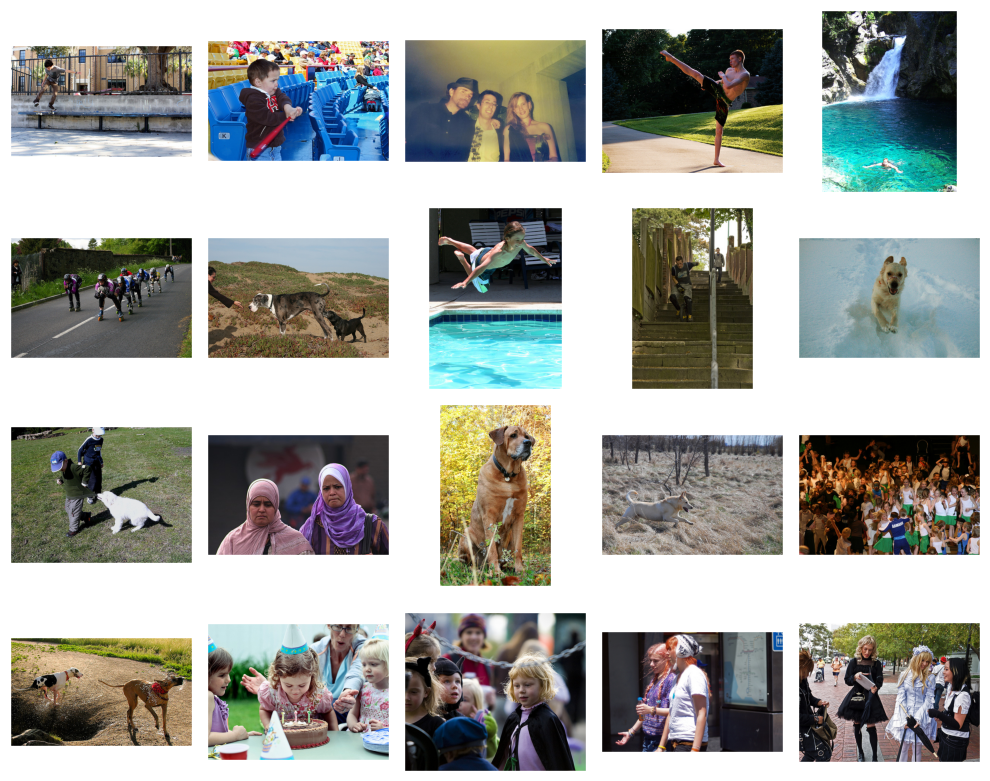

In [232]:
#проанализируем фото в данных

random_photo_train = data_train['image'].sample(10).to_list()
random_photo_test = test_queries['image'].sample(10).to_list()

path_ = '/content/drive/MyDrive'

fig = plt.figure(figsize=(10,10))
for i in range(10):
    fig.add_subplot(5, 5, i+1)
    image = Image.open(Path(path_, 'train_images', random_photo_train[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
for i in range(10):
    fig.add_subplot(5, 5, i+11)
    image = Image.open(Path(path_, 'test_images', random_photo_test[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()


Был проведен анализ данных: даны данные по трейну - данные по фото и его текстовое описание, также тест. Дополнительно есть данные по оценкам - экспертные оценки и оценки на краудфайдинговой платформе.
Далее необходимо объединить данные массивы и усреднить оценки.

Пересечения между трейном и тестом не выявлено.

#1.2. Агрегирование оценок

In [233]:
#создадим функцию, которая будет проводить агрегацию оценок экспертных данных
#по сути мы можем рассчитать моду (а в данном случае можно взять целое от медианы), в случае если не будет повторов - воспользуемся средним значением оценок
#более того оценки нужно привести в формат от 0 до 1

def exp_agr(row):
  if row['first'] != row['second'] != row['third']:
    row['exp_agr'] = (row['first'] + row['second'] + row['third'] - 3) / 3 / 3
  else:
    row['exp_agr'] = (max(set([row['first'], row['second'], row['third']]), key = [row['first'], row['second'], row['third']].count) - 1) / 3
  return row

In [234]:
 ExpertAnnotations = ExpertAnnotations.progress_apply(exp_agr, axis=1)

100%|██████████| 5822/5822 [00:05<00:00, 1118.06it/s]


In [235]:
ExpertAnnotations['exp_agr'].unique()

array([0.        , 0.33333333, 0.66666667, 1.        , 0.44444444])

In [236]:
#для объединения данных воспользуемся мержем - полным объединением

data_total_score = pd.merge(ExpertAnnotations,CrowdAnnotations, how = 'outer', on = ['image', 'query_id'])

In [237]:
data_total_score.shape

(51323, 9)

In [238]:
data_total_score.head()

image                     query_id  first  second  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2    1.0     1.0   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2    1.0     1.0   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2    1.0     1.0   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2    1.0     2.0   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2    1.0     1.0   

   third   exp_agr  share_pos  count_pos  count_neg  
0    1.0  0.000000        0.0        0.0        3.0  
1    2.0  0.000000        0.0        0.0        3.0  
2    2.0  0.000000        NaN        NaN        NaN  
3    2.0  0.333333        NaN        NaN        NaN  
4    2.0  0.000000        NaN        NaN        NaN

In [239]:
#объединим оценки

def agr_total(row):
  if np.isnan(row['exp_agr']):
        row['score'] = row['share_pos']
  elif np.isnan(row['share_pos']):
        row['score'] = row['exp_agr']
  else:
        row['score'] = row['exp_agr'] * 0.6 + row['share_pos'] * 0.4

  return row


In [240]:
data_total_score = data_total_score.progress_apply(agr_total, axis=1)

100%|██████████| 51323/51323 [01:23<00:00, 613.95it/s] 


In [241]:
#проанализируем структуру датасета с оценками
display(data_total_score['score'].unique())
display(data_total_score['score'].describe())

array([0.        , 0.33333333, 0.2       , 0.53333333, 0.4       ,
       0.33333333, 0.66666667, 0.86666667, 1.        , 0.8       ,
       0.46666667, 0.66666667, 0.13333333, 0.73333333, 0.5       ,
       0.6       , 0.28      , 0.56      , 0.4       , 0.72      ,
       0.3       , 0.44444444, 0.7       , 0.1       , 0.33333333,
       0.66666667, 0.25      , 0.2       , 0.75      , 0.16666667])

count    51323.000000
mean         0.075049
std          0.207266
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: score, dtype: float64

In [242]:
#далее заполним целевым признаком датасет трейна
data_train = pd.merge(data_train, data_total_score[['image', 'query_id', 'score']],on=['image', 'query_id'])

In [243]:
data_train.shape

(5822, 4)

Был проведен анализ, предобработка данных - были проанализированы оценки и они были агрегированы.
Далее дата трейн по оценкам был дополнен.

# 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:
⎪ This image is unavailable in your country in compliance with local laws

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.


In [244]:
#наша цель избавиться от запрещенного контента - упоминания детей, составим список
stop_child_words = ['teenage', 'baby', 'child', 'teenager', 'girl', 'boy', 'kid']

In [245]:
#nlp = spacy.load('en_core_web_sm')

#def func(text):
 #   text = re.sub(r'[^a-zA-Z]', ' ', text)
  #  text = text.lower()
   # lemm = nlp(text)
    #lemm = " ".join([token.lemma_ for token in lemm])
    #return lemm
    #" ".join(lemm.split())

lemmatize = nltk.WordNetLemmatizer()

def func(text):

    text = re.sub('[^a-zA-Z]', ' ', text).lower()
    text = nltk.word_tokenize(text, language = 'english')
    text = [lemmatize.lemmatize(word) for word in text]

    return text

def stop_child_words_(row):
    text = func(row['query_text'])
    if [i for i in text if i in stop_child_words]:
      row['ind_block'] = 1
    else: row['ind_block'] = 0
    return row

In [246]:
data_train = data_train.progress_apply(stop_child_words_,axis = 1)

100%|██████████| 5822/5822 [00:06<00:00, 908.21it/s]


In [247]:
data_train['ind_block'].unique()

array([1, 0])

In [248]:
#проверим что было заблокировано
print(data_train[data_train['ind_block'] == 1]['query_text'].sample(3).unique())


['A man balances on his forearms while a child watches in front of a colorful background .'
 'A girl with a bucket of water is being chased by a boy with a bucket of water .'
 'A girl in jeans tries to show an adult how high she can kick .']


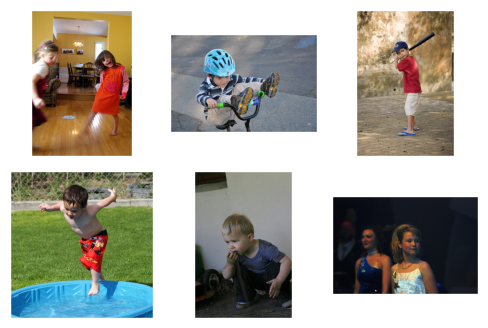

In [249]:
#проанализируем заблокированные фото
random_ = data_train[data_train['ind_block'] == 1]['query_id'].sample(6).to_list()
random_ = [i[:-2] for i in random_]

fig = plt.figure(figsize=(5,5))
for i in range(6):
    fig.add_subplot(3, 3, i+1)
    image = Image.open(Path(path_, 'train_images', random_[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()


In [250]:
#данные по фотографиям правильно заблокированы
#удалим данные строки
data_train.drop(data_train[data_train['ind_block'] == 1].index, inplace=True, errors='ignore')
data_train.drop(columns='ind_block', inplace=True, errors='ignore')
data_train.reset_index(inplace=True, drop=True)


In [251]:
#проанализируем результаты

display(data_train.head())
display(data_train.info())

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
1  3187395715_f2940c2b72.jpg  3181701312_70a379ab6e.jpg#2   
2   463978865_c87c6ca84c.jpg  3181701312_70a379ab6e.jpg#2   
3   488590040_35a3e96c89.jpg  3181701312_70a379ab6e.jpg#2   
4   534875358_6ea30d3091.jpg  3181701312_70a379ab6e.jpg#2   

                                        query_text     score  
0  A man sleeps under a blanket on a city street .  0.000000  
1  A man sleeps under a blanket on a city street .  0.333333  
2  A man sleeps under a blanket on a city street .  0.200000  
3  A man sleeps under a blanket on a city street .  0.333333  
4  A man sleeps under a blanket on a city street .  0.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4287 entries, 0 to 4286
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       4287 non-null   object 
 1   query_id    4287 non-null   object 
 2   query_text  4287 non-null   object 
 3   score       4287 non-null   float64
dtypes: float64(1), object(3)
memory usage: 134.1+ KB


None

Данные были очищены от запрещенного контента.
Приступим к дальнейшей работе - векторизируем изображения

# 3. Векторизация изображений

Воспользуемся ResNet-18. Веса при этом возьмем с 'imagenet'. Оставим сверточные слои, полносвязные слои (полносвязные по предсказаниям) уберем.

Скрипт далее был запущен отдельно, на выходе получены векторы.

In [252]:
weights = models.ResNet18_Weights.DEFAULT
preprocess = weights.transforms()
preprocess

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [253]:
resnet = models.resnet18(weights=weights)
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [254]:
modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules)
for param in resnet.parameters():
    param.requires_grad_(False)
resnet.to(device)
resnet.eval();

In [255]:
def get_image_embeddings(data_folder, image_list):
    image_embeddings = []
    for image in image_list:
        img = Image.open(os.path.join(data_folder, image)).convert('RGB')
        input_tensor = preprocess(img).unsqueeze(0).to(device)
        embeddings = resnet(input_tensor).squeeze(0).flatten().to('cpu').numpy()
        image_embeddings.append(embeddings)

    image_embeddings = np.array(image_embeddings)
    return image_embeddings

In [256]:
image_embeddings = get_image_embeddings(image_path_for_f, data_train.image.to_list())
image_embeddings.shape

(4287, 512)

Векторизовали фото, следующий этап - векторизация текстов.

# 4. Векторизация текста

Проведем векторизацию с помщью BERT.

In [257]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.to(device)

def get_text_embeddings(text_list):
    tokens_bert = bert_tokenizer(text_list,
                                 padding=True,
                                 truncation=True,
                                 add_special_tokens=True,
                                 return_attention_mask=True,
                                 return_token_type_ids=False,
                                 return_tensors='pt').to(device)
    range_start = 0
    range_end = len(tokens_bert.input_ids)
    batch_size = 100
    text_embeddings = list()
    for i in range(range_start, range_end, batch_size):
        batch_start = i
        batch_end = i + batch_size
        batch_token = tokens_bert.input_ids[batch_start:batch_end]
        batch_mask = tokens_bert.attention_mask[batch_start:batch_end]
        with torch.no_grad():
            batch_embeddings = bert_model(batch_token, attention_mask=batch_mask)
        text_embeddings.append(batch_embeddings.last_hidden_state[:, 0, :].cpu())

    text_embeddings = np.concatenate(text_embeddings)
    return text_embeddings

In [258]:
%%time
text_embeddings = get_text_embeddings(data_train.query_text.to_list())
text_embeddings.shape

CPU times: user 8min, sys: 9.01 s, total: 8min 9s
Wall time: 8min 50s


(4287, 768)

# 5. Объединяем векторы

Объединим векторы и изображения.

In [259]:
def concat_embeddings(image_embeddings, text_embeddings):
    df = pd.concat([
            pd.DataFrame(data=image_embeddings, columns=[f'imgemb{i}' for i in range(image_embeddings.shape[1])]),
            pd.DataFrame(data=text_embeddings, columns=[f'txtemb{i}' for i in range(text_embeddings.shape[1])]),
        ], axis=1)
    df.columns = df.columns.astype(str)
    return df

In [260]:
emb_train = concat_embeddings(image_embeddings, text_embeddings)
emb_train.shape

(4287, 1280)

# 6.Обучение модели предсказания соответствия

In [261]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=seed_)
train_indices, test_indices = next(gss.split(X=emb_train, groups=data_train['image']))

In [262]:
X_train, X_test = emb_train.loc[train_indices], emb_train.loc[test_indices]
y_train, y_test = data_train.loc[train_indices,'score'], data_train.loc[test_indices, 'score']

In [263]:
X_train.head()

imgemb0   imgemb1   imgemb2   imgemb3   imgemb4   imgemb5   imgemb6  \
1  0.271913  2.482275  1.619974  1.238905  1.795557  0.700188  0.333722   
3  1.519509  1.070954  0.178771  0.297532  0.567791  0.143536  1.374603   
4  0.341053  3.860156  1.173057  0.526687  0.542607  0.759330  0.779954   
6  0.837590  1.501057  0.959359  1.270147  1.306948  0.662129  1.077804   
7  0.271420  0.355587  0.547357  0.212855  0.895986  0.043340  0.074860   

    imgemb7   imgemb8   imgemb9  ...  txtemb758  txtemb759  txtemb760  \
1  0.682629  0.458916  0.705006  ...  -0.113070  -0.112948  -0.309222   
3  0.297598  0.276965  0.112594  ...  -0.113070  -0.112948  -0.309222   
4  0.009413  0.828654  0.141454  ...  -0.113070  -0.112948  -0.309222   
6  1.444690  1.266686  0.678484  ...  -0.033178   0.282282  -0.214147   
7  2.195065  1.404376  2.887155  ...  -0.033178   0.282282  -0.214147   

   txtemb761  txtemb762  txtemb763  txtemb764  txtemb765  txtemb766  txtemb767  
1  -0.056992   0.130479   0.988333  -0.092634  -0.319207   0.430009   0.243055  
3  -0.056992   0.130479   0.988333  -0.092634  -0.319207   0.430009   0.243055  
4  -0.056992   0.130479   0.988333  -0.092634  -0.319207   0.430009   0.243055  
6   0.347063   0.388014   0.896650   0.471118  -0.301246   0.148654   0.346312  
7   0.347063   0.388014   0.896650   0.471118  -0.301246   0.148654   0.346312  

[5 rows x 1280 columns]

In [264]:
print('Размер трейна', X_train.shape)
print('Размер теста', X_test.shape)

Размер трейна (3003, 1280)
Размер теста (1284, 1280)


используем две модели - ЛР и NN. Используем метрику - RMSE. Функцию потерь - MSE.

In [265]:
class NeuralNet(nn.Module):

    def __init__(self, *args, num_epochs=150, batch_size=50, dropout_n=0, learning_rate=0.0001):

        super(NeuralNet, self).__init__()

        self._estimator_type = 'regressor'
        self.input_n, self.hidden, self.output_n = args

        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.dropout_n = dropout_n
        self.learning_rate = learning_rate

        self.layer_list = nn.Sequential(
            nn.Linear(self.input_n, self.hidden),
            nn.Tanh(),
            nn.BatchNorm1d(self.hidden),
            nn.Linear(self.hidden, self.hidden),
            nn.ReLU(),
            nn.Dropout(p=self.dropout_n),
            nn.Linear(self.hidden, self.hidden),
            nn.ReLU(),
            nn.Linear(self.hidden, self.hidden),
            nn.ReLU(),
            nn.Linear(self.hidden, self.output_n),   # линейный выход
        )

    def forward(self, x):
        for layer in self.layer_list:
            x = layer(x)
        return x

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        self.dp = nn.Dropout(p=self.dropout_n)
        return self

    def init_weights(self, layer):
        if type(layer) == nn.Linear:
            nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')

    def fit(self, x, y):
        x = torch.FloatTensor(x)
        y = torch.FloatTensor(y.values)
        self.apply(self.init_weights)
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        loss = nn.MSELoss()
        num_batches = int(np.ceil(x.shape[0]/self.batch_size))
        for epoch in range(self.num_epochs):
            order = np.random.permutation(len(x))
            for batch_idx in range(num_batches):
                start_index = batch_idx * self.batch_size
                optimizer.zero_grad()
                batch_indexes = order[start_index:start_index+self.batch_size]
                X_batch = x[batch_indexes]
                y_batch = y[batch_indexes]
                preds = self.forward(X_batch).flatten()
                loss_value = loss(preds, y_batch)
                loss_value.backward()
                optimizer.step()

    def predict(self, x):
        x = torch.FloatTensor(x)
        self.eval()
        return self.forward(x).detach().numpy()[:,0]

In [266]:
%%time
model_list = [
    LinearRegression(n_jobs=-1),
    NeuralNet(512+768, 256, 1, num_epochs=500, batch_size=50, dropout_n=0.1, learning_rate=0.0001)
    ]

model_result = pd.DataFrame(columns=['model_name', 'model', 'rmse'])
for model in model_list:
    pipe = Pipeline([
        ('scale', StandardScaler()),
        ('model', model)
    ])
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    model_name = type(pipe[-1]).__name__
    model_result.loc[len(model_result)] = {
        'model_name': model_name,
        'model': pipe,
        'rmse': mean_squared_error(y_test, y_pred, squared=False)
        }

model_result.sort_values(by='rmse')

CPU times: user 5min, sys: 911 ms, total: 5min 1s
Wall time: 5min 4s


model_name                                              model  \
1         NeuralNet  (StandardScaler(), NeuralNet(\n  (layer_list):...   
0  LinearRegression    (StandardScaler(), LinearRegression(n_jobs=-1))   

       rmse  
1  0.236502  
0  5.363145

In [267]:
best_model = model_result.iloc[model_result['rmse'].argmin()]['model']
best_model

Pipeline(steps=[('scale', StandardScaler()),
                ('model',
                 NeuralNet(
  (layer_list): Sequential(
    (0): Linear(in_features=1280, out_features=256, bias=True)
    (1): Tanh()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=1, bias=True)
  )
))])

Лучшая метрика - по данным NN. Используем ее.

# 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки test_images, выберите случайные 10 запросов из файла test_queries.csv и для каждого запроса выведите наиболее релевантное изображение.

массив для теста будет очищен он запрещенного контента.

Рассчитываем тест. эмбы.

После этого нашей моделью определяем наиболее подходящее фото.

Рассчитываем кос. расстояние

И сравниваем с оригиналом.

In [269]:
test_queries_test_f = test_queries.progress_apply(stop_child_words_,axis = 1)

100%|██████████| 500/500 [00:00<00:00, 938.09it/s]


In [270]:
#дропнем запрещенный конт
test_queries_test_f.drop(test_queries_test_f[test_queries_test_f['ind_block'] == 1].index, inplace=True, errors='ignore')
test_queries_test_f.drop(columns='ind_block', inplace=True, errors='ignore')
test_queries_test_f.reset_index(inplace=True, drop=True)

In [271]:
#получим эмбы для всего теста
image_path_for_f_test = '/content/drive/MyDrive/test_images'
image_embeddings_test = get_image_embeddings(image_path_for_f_test, test_queries_test_f.image.to_list())
image_embeddings_test.shape

(331, 512)

In [272]:

def get_image(query, image_emded, data_image):

    data_len = len(image_emded)

    query_text = query.query_text
    text_embed = get_text_embeddings(query_text)[0]
    true_image = query.query_id.split('#')[0]
    true_embed = get_image_embeddings(image_path_for_f_test, [true_image])[0]

    preds = []
    dist = []
    for i in range(data_len):
        X = concat_embeddings(
            image_emded[i].reshape(1,-1),
            text_embed.reshape(1,-1)
        )
        preds.append(best_model.predict(X)[0])
        dist.append(cosine(true_embed, image_emded[i]))

    max_idx = np.argmax(preds)
    cos_idx = np.array(dist).argsort()[1]

    return {'txt': query_text,
            'src': true_image,
            'img_by_pred': data_image.iloc[max_idx].image,
            'img_by_dist': data_image.iloc[cos_idx].image,
            'cos': dist[cos_idx],
            'scr': preds[max_idx],
            'cos_idx': cos_idx,
            'max_idx': max_idx
           }

In [273]:
test_queries_test_f_random = test_queries_test_f.sample(10)


result = pd.DataFrame(columns=['txt', 'src', 'img_by_pred', 'img_by_dist', 'cos', 'scr', 'cos_idx', 'max_idx'])
for sample in test_queries_test_f_random.itertuples():
    preds = get_image(sample, image_embeddings_test, test_queries)
    result.loc[len(result)] = preds

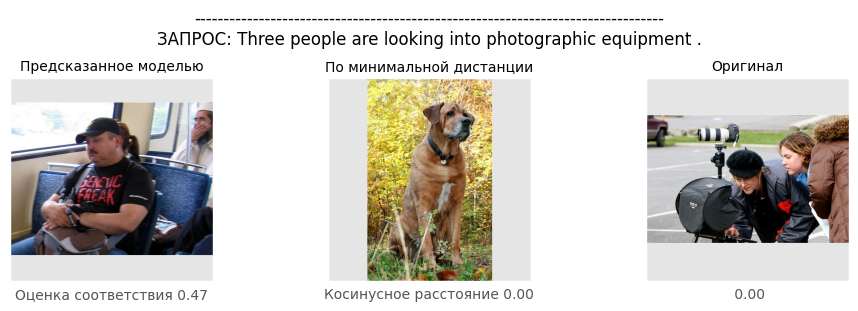

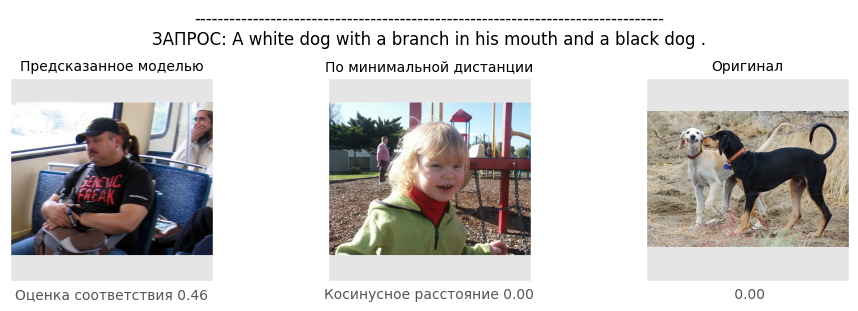

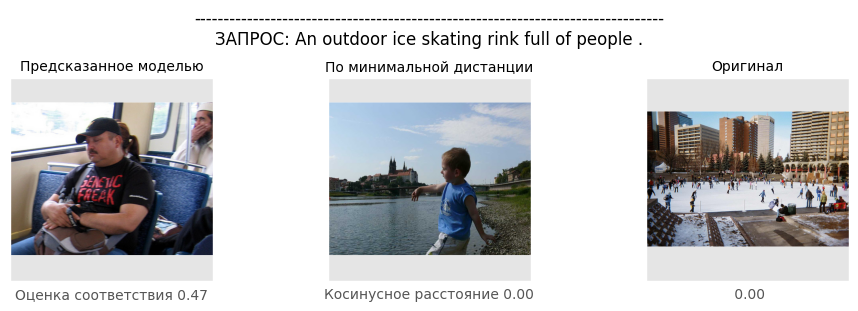

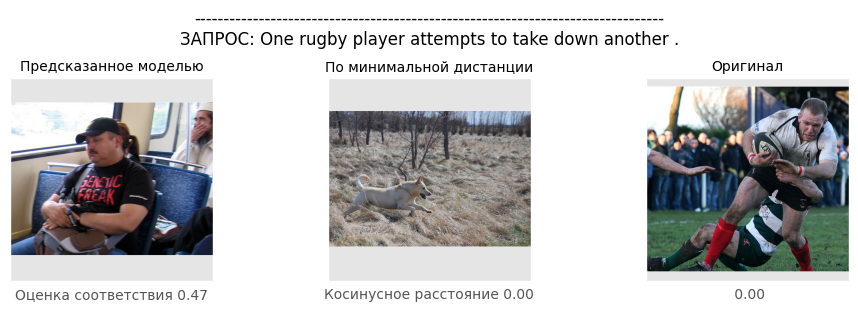

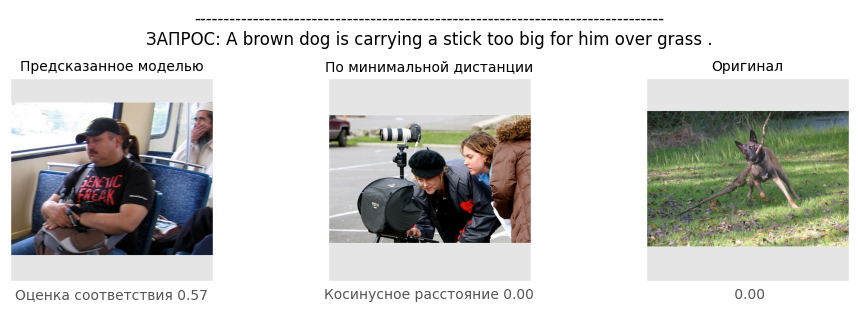

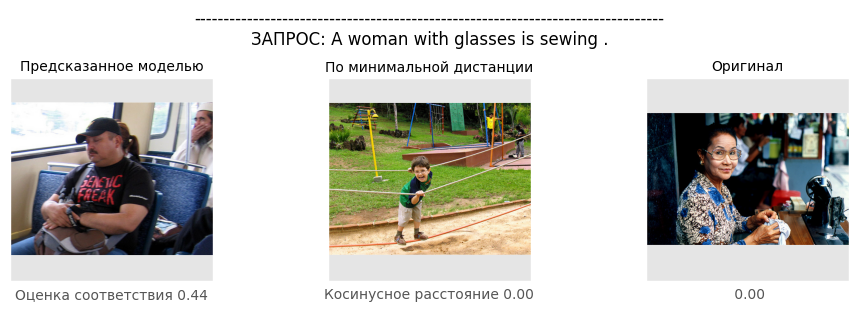

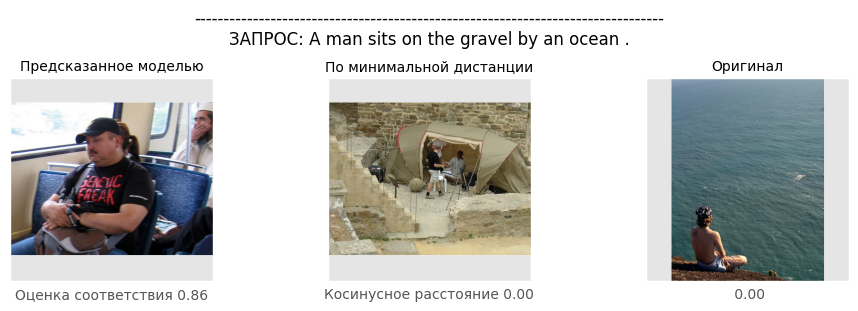

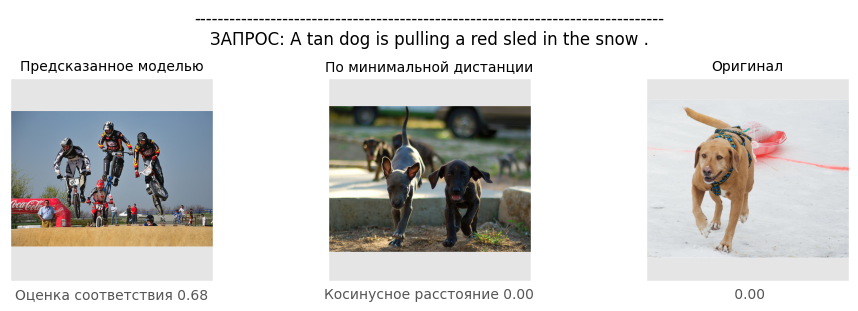

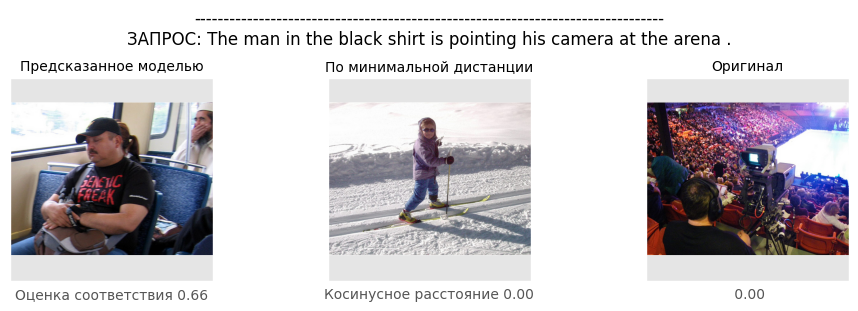

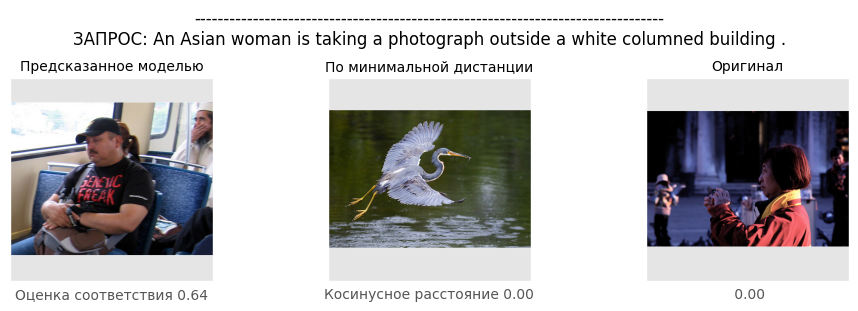

In [274]:
open_image = lambda x: Image.open(os.path.join(image_path_for_f_test, x))

def make_square(im, min_size=256, fill_color=(255, 255, 255, 0)):
    x, y = im.size
    size = max(min_size, x, y)
    new_im = Image.new('RGBA', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return new_im

def result_plot(n, img, title, score, label_score):
    fig.add_subplot(1,3,n).set_title(title, fontsize=10)
    plt.imshow(make_square(img))
    plt.xlabel(f'{label_score} {score:.2f}', fontsize=10)
    plt.xticks([])
    plt.yticks([])

for row in result.itertuples():
    fig = plt.figure(figsize=(9, 3))
    plt.suptitle(f'{"-"*80}\nЗАПРОС: {row.txt}')

    img_pred = open_image(row.img_by_pred)
    img_dist = open_image(row.img_by_dist)
    img_src = open_image(row.src)

    result_plot(1, img_pred, 'Предсказанное моделью', row.scr, 'Оценка соответствия')
    result_plot(2, img_dist, 'По минимальной дистанции', row.cos, 'Косинусное расстояние')
    result_plot(3, img_src, 'Оригинал', 0, '')

    plt.tight_layout(w_pad=6)
    plt.show()

Данные очищены от запрещенного контента.

Векторизированы изображения и текст.

Наилучшая модель nn с качеством 0,24 по RMSE.

Построена тестовая функция.


Результаты откровенно неверные.

Возможно дело в недостаточном количестве фото и данных в трейне.